# Import

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew, kurtosis
from scipy import stats
import statsmodels.api as sm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


# EDA

In [3]:
# not useful
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
# drop id
train = train.drop("Id", axis=1)
test = test.drop("Id", axis=1)


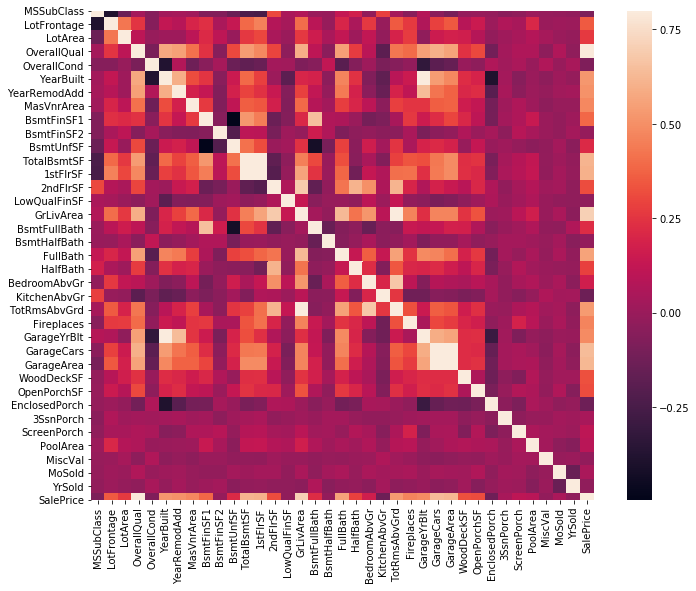

In [5]:
# Not useful. 1, big cov<y, xi>; 2, delete colinear x. 

corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

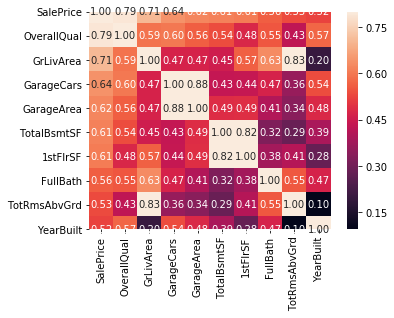

In [6]:
# Get 10 most relevant x. For caterory feature, plot_categories(train , cat = 'x' , target = 'SalePrice') see https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
hm = sns.heatmap(cm, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

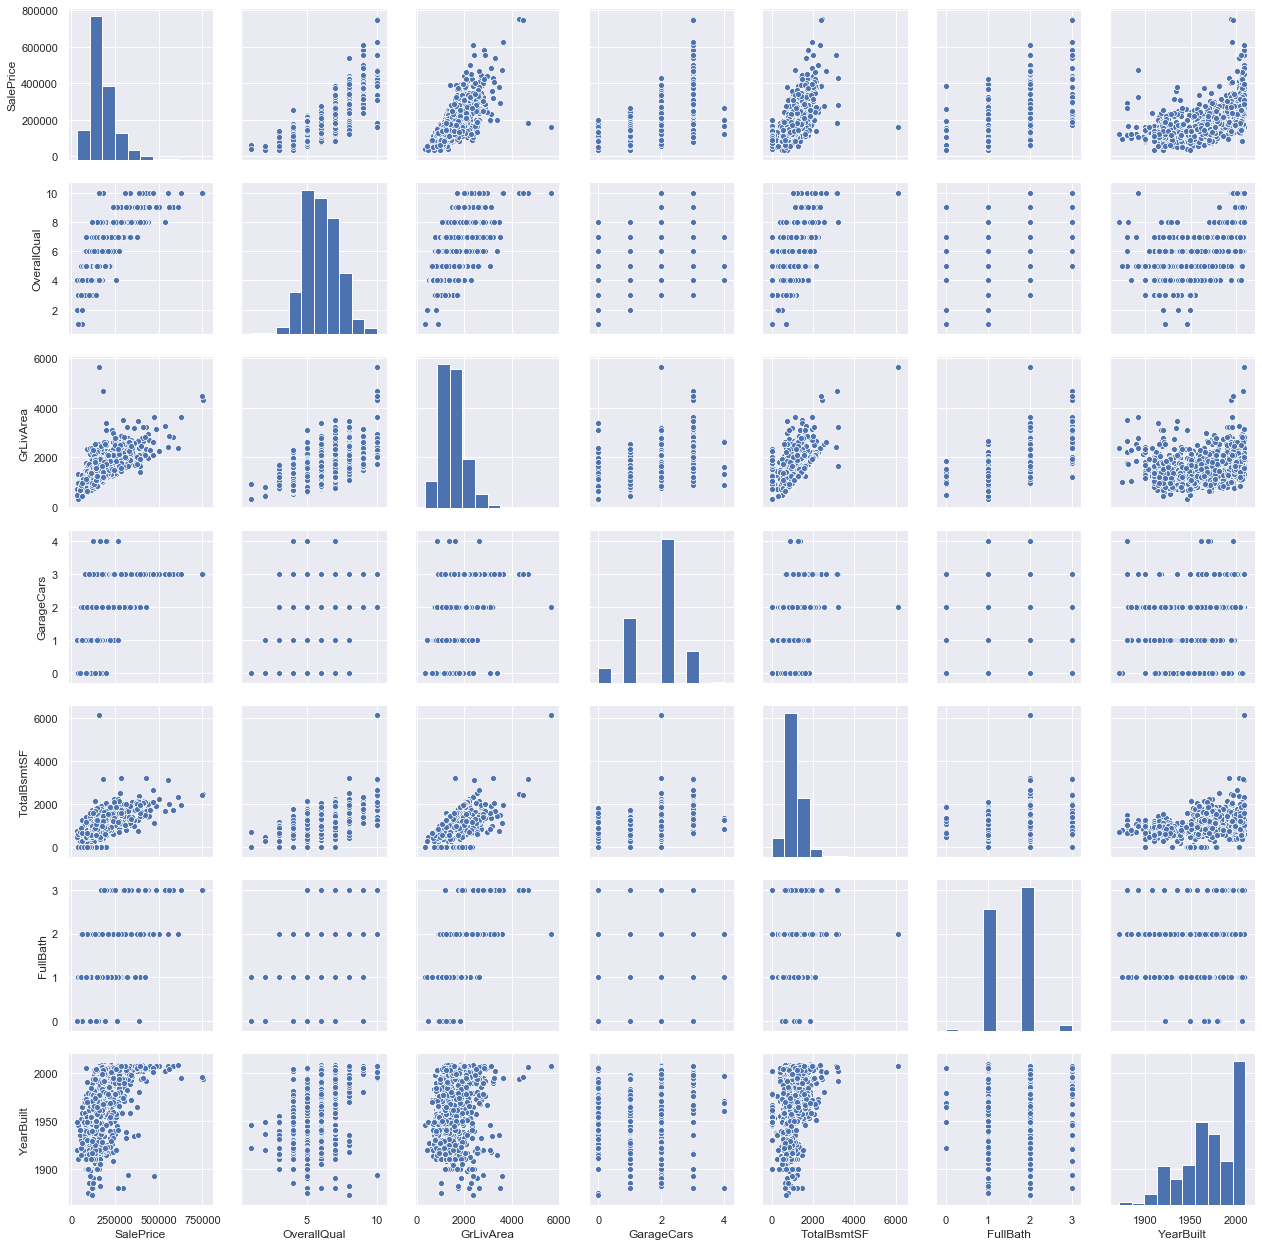

In [7]:
# Remove those with r2>0.8. 
# Find outliers (not in the trend) in first line, y=x^n, non-normal distribution(boxcox solves this automatically).
# scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])
plt.show()

# Preprocessing

## Manually remove outliers
don't remove too many.

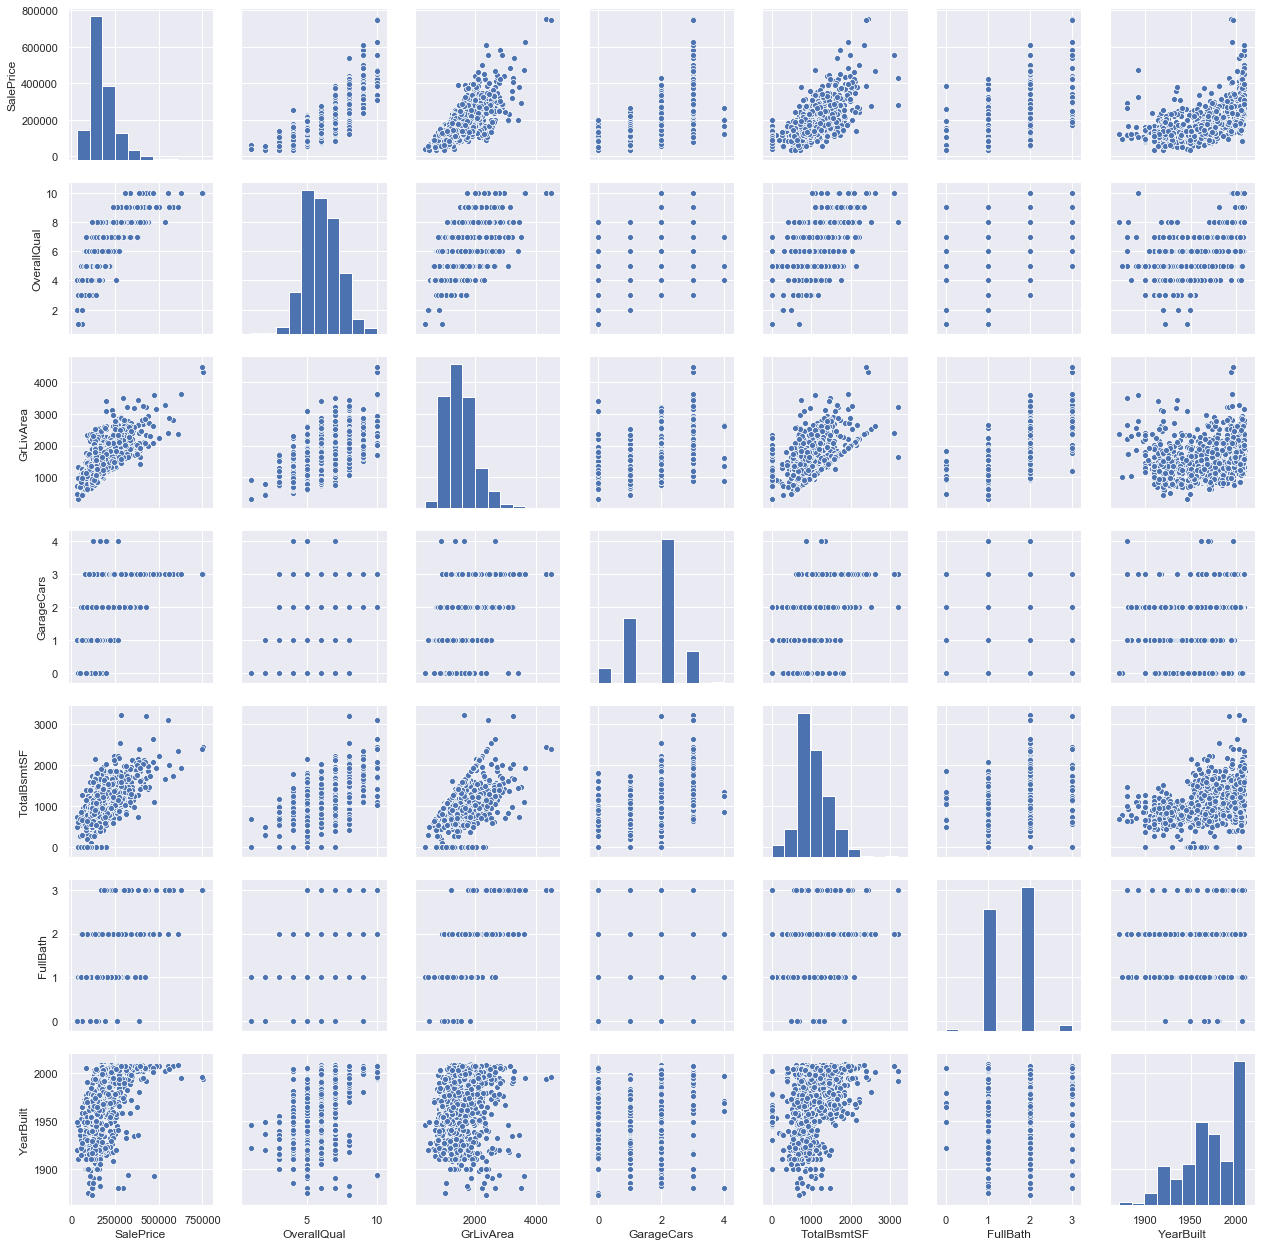

In [8]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)
train = train.drop(train[(train['TotalBsmtSF'] > 5000)].index)
sns.pairplot(train[cols])
plt.show()

## Remove features with 10% missing data.

In [9]:
# combine train and test data for the handling missing data and feature engineering (not outliers).
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.shape

/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(2917, 80)

In [10]:
# missing data.
# No features should be dropped, because the top ones has explanations in files.
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Missing Total', 'Percent'])
missing_data.head(20)

,Missing Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
SalePrice,1459,0.500171
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


## Fill missing data by its description/common sense

In [11]:
# Alley : data description says NA means "no alley access"
all_data.loc[:, "Alley"] = all_data.loc[:, "Alley"].fillna("None")
# BsmtQual etc : data description says NA for basement features is "no basement"
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("No")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("No")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("No")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("No")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("No")
all_data.loc[:, "BsmtFullBath"] = all_data.loc[:, "BsmtFullBath"].fillna(0)
all_data.loc[:, "BsmtHalfBath"] = all_data.loc[:, "BsmtHalfBath"].fillna(0)
all_data.loc[:, "BsmtUnfSF"] = all_data.loc[:, "BsmtUnfSF"].fillna(0)
# Fence : data description says NA means "no fence"
all_data.loc[:, "Fence"] = all_data.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("No")
all_data.loc[:, "Fireplaces"] = all_data.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
all_data.loc[:, "Functional"] = all_data.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("No")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("No")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("No")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("No")
all_data.loc[:, "GarageArea"] = all_data.loc[:, "GarageArea"].fillna(0)
all_data.loc[:, "GarageCars"] = all_data.loc[:, "GarageCars"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
all_data.loc[:, "MiscFeature"] = all_data.loc[:, "MiscFeature"].fillna("No")
all_data.loc[:, "MiscVal"] = all_data.loc[:, "MiscVal"].fillna(0)
# PoolQC : data description says NA means "no pool"
all_data.loc[:, "PoolQC"] = all_data.loc[:, "PoolQC"].fillna("No")
all_data.loc[:, "PoolArea"] = all_data.loc[:, "PoolArea"].fillna(0)


## Numeric/Category Wrong
Ordered Category should be numeric

In [12]:
# Some numerical features are actually really categories
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)


# Encode some categorical features as ordered numbers when there is information in the order
all_data = all_data.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

## Other missing data

In [13]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
all_data = DataFrameImputer().fit_transform(all_data)
all_data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SalePrice,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,...,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,1157.692492,335.861502,2.604045,2.860130,2.918409,0.650326,438.991087,49.599246,3.539938,1.273912,...,171963.385670,16.073363,1.995886,6.448063,1049.306651,3.999314,93.629414,1971.287967,1984.248200,2007.792938
std,385.264298,428.119663,25.196714,0.822967,0.575143,1.038249,444.108106,169.232130,2.113595,0.955481,...,56903.336431,56.202054,0.064018,1.564281,429.033799,0.037031,126.532643,30.286991,20.892257,1.315328
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,34900.000000,0.000000,1.000000,2.000000,0.000000,2.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,163000.000000,0.000000,2.000000,5.000000,793.000000,4.000000,0.000000,1953.000000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,3.000000,0.000000,368.000000,0.000000,4.000000,1.000000,...,163000.000000,0.000000,2.000000,6.000000,988.500000,4.000000,0.000000,1973.000000,1993.000000,2008.000000
75%,1384.000000,704.000000,0.000000,3.000000,3.000000,1.000000,733.000000,0.000000,6.000000,1.000000,...,163000.000000,0.000000,2.000000,7.000000,1302.000000,4.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,4.000000,3.000000,4010.000000,1526.000000,6.000000,6.000000,...,755000.000000,576.000000,2.000000,15.000000,5095.000000,4.000000,1424.000000,2010.000000,2010.000000,2010.000000


In [14]:
# no missing data now
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Missing Total', 'Percent'])
missing_data.head(20)

,Missing Total,Percent
YrSold,0,0.0
YearRemodAdd,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
Fence,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Foundation,0,0.0


## Optional: automatically remove outliers
May remove too many points if we have lots of x. Not useful here.

In [15]:
# Method 1: IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return df[trueList.all(axis=1)]

#train = remove_outliers(train)
#print(train.shape)

# Method 2: 3 sigma
#df = train[(np.abs(stats.zscore(train.select_dtypes(exclude = ["object"]))) < 3).all(axis=1)]

## Feature Engineering
Get $x_1$ + $x_2$ or $x_1$ * $x_2$ by common sense; get $x^n$ and $x_1$ * $x_2$ for the most relavant features.

In [16]:
# common sense
# Overall quality of the house
all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]
# Overall quality of the garage
all_data["GarageGrade"] = all_data["GarageQual"] * all_data["GarageCond"]
# Overall quality of the exterior
all_data["ExterGrade"] = all_data["ExterQual"] * all_data["ExterCond"]
# Overall kitchen score
all_data["KitchenScore"] = all_data["KitchenAbvGr"] * all_data["KitchenQual"]
# Overall fireplace score
all_data["FireplaceScore"] = all_data["Fireplaces"] * all_data["FireplaceQu"]
# Overall garage score
all_data["GarageScore"] = all_data["GarageArea"] * all_data["GarageQual"]
# Overall pool score
all_data["PoolScore"] = all_data["PoolArea"] * all_data["PoolQC"]
# Total number of bathrooms
all_data["TotalBath"] = all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"]) + \
all_data["FullBath"] + (0.5 * all_data["HalfBath"])
# Total SF for house (incl. basement)
all_data["AllSF"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
all_data["AllFlrsSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# Total SF for porch
all_data["AllPorchSF"] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + \
all_data["3SsnPorch"] + all_data["ScreenPorch"]

In [17]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending=False, inplace=True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000000
OverallQual      0.795774
GrLivArea        0.734968
TotalBsmtSF      0.651153
GarageCars       0.641047
1stFlrSF         0.631530
GarageArea       0.629217
FullBath         0.562165
TotRmsAbvGrd     0.537769
YearBuilt        0.523608
YearRemodAdd     0.507717
GarageYrBlt      0.487156
MasVnrArea       0.482719
Fireplaces       0.469862
BsmtFinSF1       0.409384
LotFrontage      0.370584
WoodDeckSF       0.324758
OpenPorchSF      0.321142
2ndFlrSF         0.320532
HalfBath         0.284590
LotArea          0.268179
BsmtFullBath     0.228459
BsmtUnfSF        0.214460
BedroomAbvGr     0.168245
ScreenPorch      0.111415
PoolArea         0.099490
MoSold           0.046124
3SsnPorch        0.044568
BsmtFinSF2      -0.011422
BsmtHalfBath    -0.016881
MiscVal         -0.021203
LowQualFinSF    -0.025625
YrSold          -0.028882
OverallCond     -0.077948
MSSubClass      -0.084276
EnclosedPorch   -0.128646
KitchenAbvGr    

In [18]:
# x^n on the top 10 existing features
all_data["OverallQual-s2"] = all_data["OverallQual"] ** 2
all_data["OverallQual-s3"] = all_data["OverallQual"] ** 3
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["AllSF-2"] = all_data["AllSF"] ** 2
all_data["AllSF-3"] = all_data["AllSF"] ** 3
all_data["AllSF-Sq"] = np.sqrt(all_data["AllSF"])
all_data["AllFlrsSF-2"] = all_data["AllFlrsSF"] ** 2
all_data["AllFlrsSF-3"] = all_data["AllFlrsSF"] ** 3
all_data["AllFlrsSF-Sq"] = np.sqrt(all_data["AllFlrsSF"])
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["ExterQual-2"] = all_data["ExterQual"] ** 2
all_data["ExterQual-3"] = all_data["ExterQual"] ** 3
all_data["ExterQual-Sq"] = np.sqrt(all_data["ExterQual"])
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["TotalBath-2"] = all_data["TotalBath"] ** 2
all_data["TotalBath-3"] = all_data["TotalBath"] ** 3
all_data["TotalBath-Sq"] = np.sqrt(all_data["TotalBath"])
all_data["KitchenQual-2"] = all_data["KitchenQual"] ** 2
all_data["KitchenQual-3"] = all_data["KitchenQual"] ** 3
all_data["KitchenQual-Sq"] = np.sqrt(all_data["KitchenQual"])
all_data["GarageScore-2"] = all_data["GarageScore"] ** 2
all_data["GarageScore-3"] = all_data["GarageScore"] ** 3
all_data["GarageScore-Sq"] = np.sqrt(all_data["GarageScore"])


## Standard preprosessing
Numerical: log, rescale

Category: one-hot

In [19]:
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index
skewness = all_data.loc[:len(train), numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to log transform".format(skewness.shape[0]))

skewed_features = skewness.index
all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 73 skewed numerical features to log transform


In [20]:
all_data = pd.get_dummies(all_data)

In [21]:
train, test= all_data[:len(train)], all_data[len(train):]

In [22]:
stdSc = StandardScaler()
train.loc[:, numeric_features] = stdSc.fit_transform(train.loc[:, numeric_features])
test.loc[:, numeric_features] = stdSc.transform(test.loc[:, numeric_features])

/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
np.std(train.loc[:, numeric_features])

1stFlrSF          1.0
2ndFlrSF          1.0
3SsnPorch         1.0
BedroomAbvGr      1.0
BsmtCond          1.0
                 ... 
KitchenQual-3     1.0
KitchenQual-Sq    1.0
GarageScore-2     1.0
GarageScore-3     1.0
GarageScore-Sq    1.0
Length: 92, dtype: float64

## Modelling

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['SalePrice'], axis=1), train['SalePrice'], test_size = 0.1)

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = scorer, cv = 10))
    return(rmse)

### Lasso

Best alpha : 0.001
Try again for more precision with alphas centered around 0.001
Best alpha : 0.00085
Lasso RMSE on Training set : 0.2802763816365733
Lasso RMSE on Test set : 0.3659835350227852


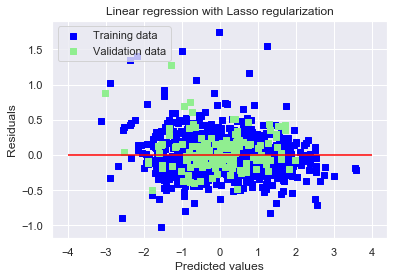

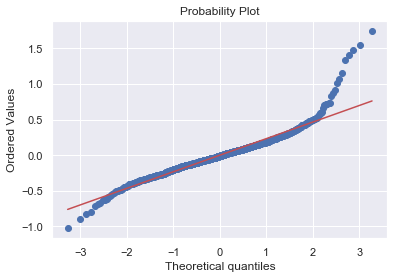

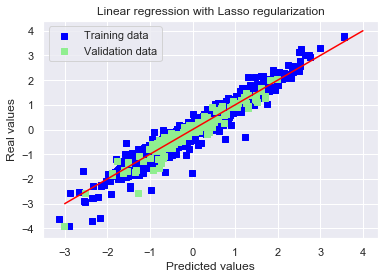

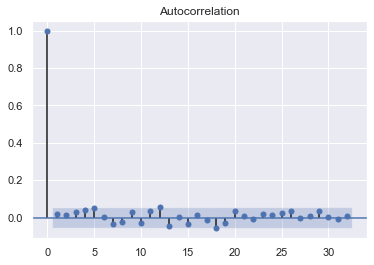

Lasso picked 137 features and eliminated the other 157 features


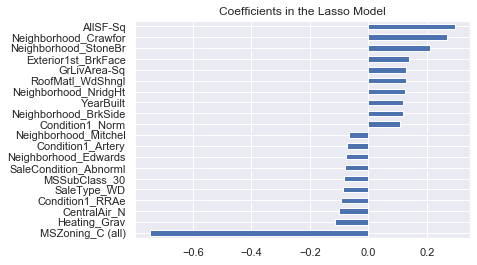

In [38]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv(lasso, X_train, y_train).mean())
print("Lasso RMSE on Test set :", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


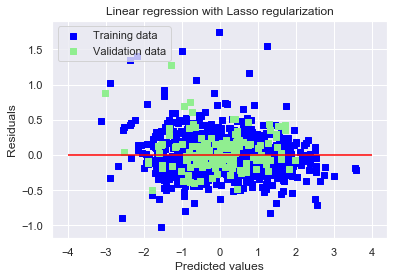

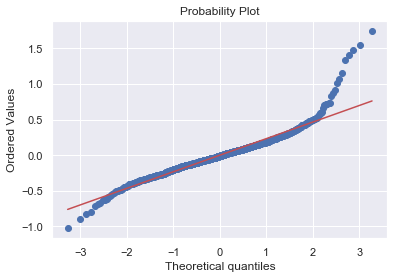

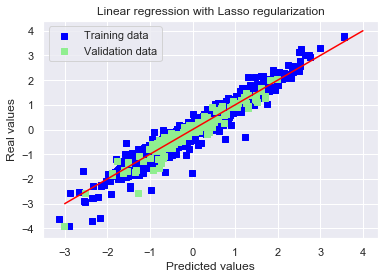

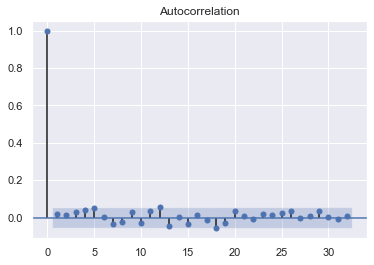

Lasso picked 137 features and eliminated the other 157 features


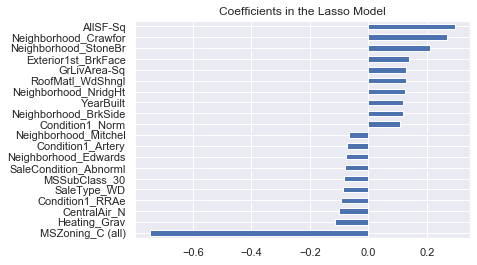

In [39]:
# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -4, xmax = 4, color = "red")
plt.show()

#Get also the QQ-plot
res = stats.probplot(y_train_las - y_train, plot=plt)
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-3, 4], [-3, 4], c = "red")
plt.show()

# check self-correlation
sm.graphics.tsa.plot_acf(y_train_las - y_train)
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()


### Discussion
#### Assumptions: stable variance; good linear; normal distributions; independence

#### Important features

In [42]:
if stats.jarque_bera(y_train_las - y_train)[1] > 0.05:
    print('Normal distribution based on JB')
else:
    print('Not Normal distribution based on JB')

Not Normal distribution based on JB


## XGBoost
get importance of features.
tune n_estimators, then early_stopping_rounds~5, then max_depth, and min_child_weight.

In [75]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.drop(['SalePrice'], axis=1).values, train['SalePrice'], scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, early_stopping_rounds=5)
score = rmsle_cv(model_xgb)
print("\nBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


[17:16:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:16:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:16:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:17:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:17:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:17:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:18:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:18:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:19:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Boost score: 0.2793 (0.0394)

[17:19:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603,
             early_stopping_rounds=5, gamma=0.0468, importance_type='gain',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=None, n_estimators=2200, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.464, reg_lambda=0.8571, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5213, verbosity=1)

In [74]:
model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=None, subsample=0.5213,
             verbosity=1)

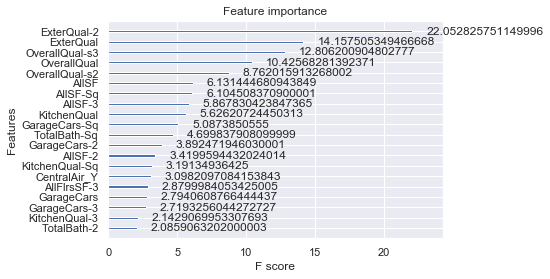

In [73]:
xgb.plot_importance(model_xgb, importance_type='gain', max_num_features=20)
plt.show()

## Average 2 models

In [67]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    
averaged_models = AveragingModels(models = (model_xgb, lasso_model))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.748737897820053, tolerance: 0.13269294643121848
  positive)
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.285751345683636, tolerance: 0.131530768996144
  positive)
/Users/chenkongtao

 Averaged base models score: 0.2621 (0.0385)



/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.67683346742703, tolerance: 0.1310190074816136
  positive)


## Discussion
Missing data: semi-supervised learning

Too many data: deep learning

High training error: get more features

Low training error, high testing error: overfitting, tune the model


# Help functions

In [76]:
# get important features, better than corr. 
def plot_variable_importance( X , y):
    tree = DecisionTreeClassifier()
    tree.fit(X , y)
    plot_model_var_imp(tree, X, y)

# for y vs category x. 
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.523124078682194, tolerance: 0.11694027019812935
  positive)
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.013375991278295, tolerance: 0.11694027019812935
  positive)
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0702856067781426, tolerance: 0.11694027019812935
  positive)
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. Y

/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.366014245211861, tolerance: 0.1193050965856448
  positive)
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5010571984652401, tolerance: 0.1193050965856448
  positive)
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.237893589542406, tolerance: 0.11829942276695463
  positive)
/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You

Lasso(alpha=0.0006, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Training error: 0.054696188289154166
Testing error: 0.07891372113573747
[ 2.03261621e-01 -8.01865306e-01 -1.81917069e+00 -4.30425340e-01
  1.40836098e-01  2.12174508e-01 -9.73188134e-02 -1.38609204e-01
  1.98494385e+00 -1.78166029e+00  1.88003120e-01  3.55377547e-01
  1.06562715e-01 -1.55606377e+00  2.56694281e-01  3.49256448e-01
  1.74048587e+00 -8.21279428e-01 -1.26094418e-02 -3.07723600e-01
 -1.40914767e+00 -6.38413672e-01 -1.86869013e-03  4.50576611e-01
 -3.14485957e-01 -4.44523652e-01 -9.33443115e-01 -7.15934327e-01
  1.66378605e+00 -4.71785244e-01  1.24964271e+00 -9.87164128e-01
  1.07566295e+00  1.15938997e+00 -8.24775175e-01  6.71749573e-01
  1.46186526e+00  1.52115688e+00  1.23638878e+00  1.04357016e+00
  5.44994462e-01  1.01859787e+00 -1.26812416e+00 -1.26254904e+00
  5.75286405e

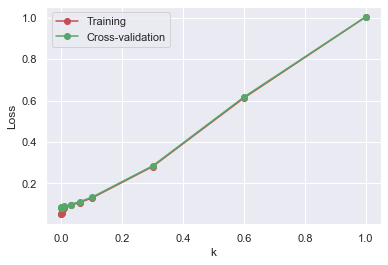

In [66]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Lasso

k_range = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1]

# train
train_loss, test_loss = validation_curve(Lasso(), X_train, y_train, scoring='neg_mean_squared_error', param_name='alpha', param_range=k_range, cv=10)
# average accuracy from cross validation in knn. scoring = 'mean_squared_error' for regression, 'accuracy' for classification. n_job for parallel
train_loss_mean = -np.mean(train_loss, axis = 1) # training error from cv
test_loss_mean = -np.mean(test_loss, axis = 1) # test error from cv

k_best = k_range[np.argmin(test_loss_mean)]
lasso_model = Lasso(alpha = k_best)
lasso_model.fit(X_train, y_train)
print(lasso_model) # print parameters
print('Training error:', train_loss_mean[np.argmin(test_loss_mean)])
print('Testing error:', np.min(test_loss_mean))

# predict
print(lasso_model.predict(X_test))
    
# plot
plt.plot(k_range, train_loss_mean, 'o-', color = "r", label = "Training")
plt.plot(k_range, test_loss_mean, 'o-', color = "g", label = "Cross-validation")
plt.xlabel("k")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()


Lasso picked 149 features and eliminated the other 145 features


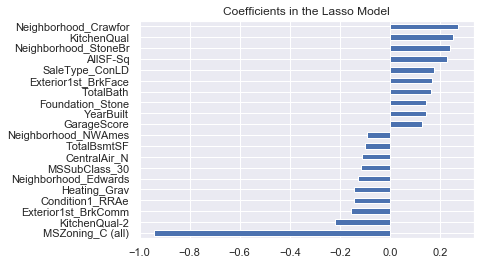

In [297]:
# Plot important coefficients
coefs = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.drop(['SalePrice'], axis=1).values, train['SalePrice'], scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0006))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Plot important coefficients
coefs = pd.Series(lasso.steps[1][1].coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

NameError: name 'Lasso' is not defined

In [312]:
lasso.steps[1][1]

Lasso(alpha=0.0006, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [71]:
d_train = xgb.DMatrix(X_train, y_train) # read from file
d_test = xgb.DMatrix(X_test, y_test)
evallist = [(d_test, 'eval'), (d_train, 'train')] # get training and test data.

# set parameters
param = {'nfold': 10, 'max_depth': 3, 'n_estimators': 2200, 'early_stopping_rounds': 5, 'metrics': 'mse',
        'colsample_bytree': 0.4603, 'gamma': 0.0468, 'learning_rate': 0.05, 'max_depth': 3, 
        'min_child_weight': 1.7817, 'n_estimators': 2200,
        'reg_alpha': 0.4640, 'reg_lambda': 0.8571, 'subsample': 0.5213} # parameters for boosting
num_round = 3000 # upper limit of times of boosting

# train
xgb.cv(param, d_train, num_boost_round=num_round, callbacks = [xgb.callback.print_evaluation(show_stdv = True), xgb.callback.early_stop(3)])# show all num_round = 1..num_round. pick the best one. every 3 boosting, exam whether perfomance is better. stop if not.
bst = xgb.train(param, d_train, num_boost_round=7, evals=evallist, early_stopping_rounds=10) # train by the best num_round
bst = xgb.train(param, d_train, num_round, evals=evallist, early_stopping_rounds=10) # train. to get best num_round, every 10 boosting, exam whether perfomance is better. stop if not. 



[0]	train-rmse:1.07332+0.0198479	test-rmse:1.07432+0.042555
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
[1]	train-rmse:1.03191+0.0179399	test-rmse:1.03364+0.0435922
[2]	train-rmse:0.992895+0.01757	test-rmse:0.995108+0.0417042
[3]	train-rmse:0.95512+0.0170331	test-rmse:0.958258+0.040407
[4]	train-rmse:0.919543+0.0163771	test-rmse:0.922629+0.0389472
[5]	train-rmse:0.88623+0.0156666	test-rmse:0.890192+0.0390695
[6]	train-rmse:0.854432+0.0152067	test-rmse:0.858974+0.0390825
[7]	train-rmse:0.823977+0.015385	test-rmse:0.829107+0.0391449
[8]	train-rmse:0.794862+0.0143269	test-rmse:0.801251+0.0385945
[9]	train-rmse:0.768114+0.0127993	test-rmse:0.774874+0.0390204
[10]	train-rmse:0.742572+0.0125651	test-rmse:0.750251+0.0382867
[11]	train-rmse:0.718722+0.0125704	test-rmse:0.727514+0.0366943
[12]	train-rmse:0.69643+0.0122469	test-rmse:0.706451+0.0362679
[13]	train-rmse:0.674555+0.0114371	test-rmse:0.6

[125]	train-rmse:0.227002+0.00495836	test-rmse:0.308617+0.0145375
[126]	train-rmse:0.226487+0.00502977	test-rmse:0.308197+0.0144633
[127]	train-rmse:0.225986+0.00495123	test-rmse:0.307895+0.0144988
[128]	train-rmse:0.225478+0.00483111	test-rmse:0.307609+0.0141989
[129]	train-rmse:0.224815+0.00507154	test-rmse:0.307503+0.0140548
[130]	train-rmse:0.224204+0.0050328	test-rmse:0.30728+0.0138417
[131]	train-rmse:0.223771+0.00495226	test-rmse:0.307009+0.0139139
[132]	train-rmse:0.223355+0.00496228	test-rmse:0.306757+0.0137934
[133]	train-rmse:0.222871+0.00493533	test-rmse:0.306367+0.0136141
[134]	train-rmse:0.22236+0.00503878	test-rmse:0.306054+0.0136998
[135]	train-rmse:0.221815+0.00499129	test-rmse:0.305616+0.0135121
[136]	train-rmse:0.221307+0.00493303	test-rmse:0.305395+0.013671
[137]	train-rmse:0.220779+0.0048986	test-rmse:0.3052+0.0135368
[138]	train-rmse:0.220238+0.00490041	test-rmse:0.305069+0.013578
[139]	train-rmse:0.219691+0.00486467	test-rmse:0.304888+0.0138091
[140]	train-rmse:0

[57]	eval-rmse:0.430474	train-rmse:0.306485
[58]	eval-rmse:0.427868	train-rmse:0.30419
[59]	eval-rmse:0.424714	train-rmse:0.30165
[60]	eval-rmse:0.421282	train-rmse:0.299059
[61]	eval-rmse:0.418506	train-rmse:0.297138
[62]	eval-rmse:0.416768	train-rmse:0.294767
[63]	eval-rmse:0.414968	train-rmse:0.292343
[64]	eval-rmse:0.413194	train-rmse:0.290085
[65]	eval-rmse:0.412608	train-rmse:0.288174
[66]	eval-rmse:0.410782	train-rmse:0.286686
[67]	eval-rmse:0.409804	train-rmse:0.285278
[68]	eval-rmse:0.408087	train-rmse:0.283437
[69]	eval-rmse:0.406101	train-rmse:0.281889
[70]	eval-rmse:0.403494	train-rmse:0.280404
[71]	eval-rmse:0.402234	train-rmse:0.278992
[72]	eval-rmse:0.400145	train-rmse:0.277654
[73]	eval-rmse:0.398872	train-rmse:0.27597
[74]	eval-rmse:0.398083	train-rmse:0.274888
[75]	eval-rmse:0.397049	train-rmse:0.273642
[76]	eval-rmse:0.395555	train-rmse:0.272316
[77]	eval-rmse:0.39392	train-rmse:0.271005
[78]	eval-rmse:0.391757	train-rmse:0.269854
[79]	eval-rmse:0.390057	train-rmse:0

[241]	eval-rmse:0.328653	train-rmse:0.20115
[242]	eval-rmse:0.328705	train-rmse:0.200868
[243]	eval-rmse:0.328837	train-rmse:0.200354
[244]	eval-rmse:0.32824	train-rmse:0.200104
[245]	eval-rmse:0.327969	train-rmse:0.199874
[246]	eval-rmse:0.327848	train-rmse:0.199562
[247]	eval-rmse:0.327973	train-rmse:0.199285
[248]	eval-rmse:0.327628	train-rmse:0.199087
[249]	eval-rmse:0.327362	train-rmse:0.198854
[250]	eval-rmse:0.327414	train-rmse:0.198581
[251]	eval-rmse:0.327207	train-rmse:0.198345
[252]	eval-rmse:0.327151	train-rmse:0.19814
[253]	eval-rmse:0.326915	train-rmse:0.197946
[254]	eval-rmse:0.326478	train-rmse:0.19773
[255]	eval-rmse:0.326408	train-rmse:0.197553
[256]	eval-rmse:0.32671	train-rmse:0.19728
[257]	eval-rmse:0.326505	train-rmse:0.197007
[258]	eval-rmse:0.32596	train-rmse:0.196812
[259]	eval-rmse:0.325764	train-rmse:0.19671
[260]	eval-rmse:0.325563	train-rmse:0.196553
[261]	eval-rmse:0.32558	train-rmse:0.196326
[262]	eval-rmse:0.325092	train-rmse:0.196085
[263]	eval-rmse:0.3

[424]	eval-rmse:0.314098	train-rmse:0.168625
[425]	eval-rmse:0.314057	train-rmse:0.168493
[426]	eval-rmse:0.31425	train-rmse:0.168325
[427]	eval-rmse:0.314317	train-rmse:0.168147
[428]	eval-rmse:0.314269	train-rmse:0.168003
[429]	eval-rmse:0.314224	train-rmse:0.167887
[430]	eval-rmse:0.313859	train-rmse:0.167671
[431]	eval-rmse:0.31392	train-rmse:0.16758
[432]	eval-rmse:0.313638	train-rmse:0.167445
[433]	eval-rmse:0.313879	train-rmse:0.167248
[434]	eval-rmse:0.314121	train-rmse:0.167091
[435]	eval-rmse:0.314071	train-rmse:0.166936
[436]	eval-rmse:0.314145	train-rmse:0.166815
[437]	eval-rmse:0.314143	train-rmse:0.166681
[438]	eval-rmse:0.31356	train-rmse:0.166526
[439]	eval-rmse:0.313472	train-rmse:0.16638
[440]	eval-rmse:0.313535	train-rmse:0.166301
[441]	eval-rmse:0.312999	train-rmse:0.166123
[442]	eval-rmse:0.312803	train-rmse:0.165969
[443]	eval-rmse:0.312721	train-rmse:0.165808
[444]	eval-rmse:0.312682	train-rmse:0.16573
[445]	eval-rmse:0.312697	train-rmse:0.165677
[446]	eval-rmse:

[608]	eval-rmse:0.304923	train-rmse:0.146579
[609]	eval-rmse:0.305031	train-rmse:0.146448
[610]	eval-rmse:0.304863	train-rmse:0.146322
[611]	eval-rmse:0.304729	train-rmse:0.146256
[612]	eval-rmse:0.304691	train-rmse:0.146161
[613]	eval-rmse:0.304522	train-rmse:0.146143
[614]	eval-rmse:0.304573	train-rmse:0.146047
[615]	eval-rmse:0.304532	train-rmse:0.145921
[616]	eval-rmse:0.304557	train-rmse:0.145833
[617]	eval-rmse:0.304489	train-rmse:0.145795
[618]	eval-rmse:0.304624	train-rmse:0.145666
[619]	eval-rmse:0.30459	train-rmse:0.145613
[620]	eval-rmse:0.304721	train-rmse:0.145489
[621]	eval-rmse:0.304594	train-rmse:0.145375
[622]	eval-rmse:0.304456	train-rmse:0.145351
[623]	eval-rmse:0.304291	train-rmse:0.145233
[624]	eval-rmse:0.3041	train-rmse:0.145189
[625]	eval-rmse:0.30417	train-rmse:0.145103
[626]	eval-rmse:0.304147	train-rmse:0.145034
[627]	eval-rmse:0.304248	train-rmse:0.14492
[628]	eval-rmse:0.304451	train-rmse:0.144851
[629]	eval-rmse:0.304438	train-rmse:0.144778
[630]	eval-rmse

[792]	eval-rmse:0.301298	train-rmse:0.132073
[793]	eval-rmse:0.30138	train-rmse:0.132012
[794]	eval-rmse:0.30134	train-rmse:0.13194
[795]	eval-rmse:0.301426	train-rmse:0.131865
[796]	eval-rmse:0.301421	train-rmse:0.131752
[797]	eval-rmse:0.30134	train-rmse:0.131669
[798]	eval-rmse:0.301144	train-rmse:0.131635
[799]	eval-rmse:0.301325	train-rmse:0.131592
[800]	eval-rmse:0.301335	train-rmse:0.131547
[801]	eval-rmse:0.301324	train-rmse:0.131446
[802]	eval-rmse:0.301444	train-rmse:0.131373
[803]	eval-rmse:0.301373	train-rmse:0.131301
[804]	eval-rmse:0.30146	train-rmse:0.131222
[805]	eval-rmse:0.301459	train-rmse:0.13116
[806]	eval-rmse:0.301256	train-rmse:0.131042
[807]	eval-rmse:0.301145	train-rmse:0.131007
[808]	eval-rmse:0.301012	train-rmse:0.130969
[809]	eval-rmse:0.300863	train-rmse:0.130909
[810]	eval-rmse:0.30085	train-rmse:0.130772
[811]	eval-rmse:0.301035	train-rmse:0.130678
[812]	eval-rmse:0.301056	train-rmse:0.130605
[813]	eval-rmse:0.301335	train-rmse:0.130568
[814]	eval-rmse:0

[975]	eval-rmse:0.300196	train-rmse:0.121389
[976]	eval-rmse:0.300169	train-rmse:0.121319
[977]	eval-rmse:0.300082	train-rmse:0.121312
[978]	eval-rmse:0.299939	train-rmse:0.121248
[979]	eval-rmse:0.300014	train-rmse:0.121215
[980]	eval-rmse:0.299993	train-rmse:0.121152
[981]	eval-rmse:0.300128	train-rmse:0.121099
[982]	eval-rmse:0.300067	train-rmse:0.121075
[983]	eval-rmse:0.299889	train-rmse:0.120913
[984]	eval-rmse:0.299779	train-rmse:0.120832
[985]	eval-rmse:0.299798	train-rmse:0.120808
[986]	eval-rmse:0.299838	train-rmse:0.120784
[987]	eval-rmse:0.299629	train-rmse:0.120715
[988]	eval-rmse:0.29956	train-rmse:0.120664
[989]	eval-rmse:0.299438	train-rmse:0.120637
[990]	eval-rmse:0.299344	train-rmse:0.120571
[991]	eval-rmse:0.299512	train-rmse:0.120528
[992]	eval-rmse:0.299518	train-rmse:0.120479
[993]	eval-rmse:0.299595	train-rmse:0.120437
[994]	eval-rmse:0.29952	train-rmse:0.120377
[995]	eval-rmse:0.299496	train-rmse:0.120352
[996]	eval-rmse:0.29936	train-rmse:0.120314
[997]	eval-rm

[1155]	eval-rmse:0.299397	train-rmse:0.114377
[1156]	eval-rmse:0.299414	train-rmse:0.114315
[1157]	eval-rmse:0.299421	train-rmse:0.114315
[1158]	eval-rmse:0.299429	train-rmse:0.114278
[1159]	eval-rmse:0.299428	train-rmse:0.11427
[1160]	eval-rmse:0.299401	train-rmse:0.114254
[1161]	eval-rmse:0.299393	train-rmse:0.114225
[1162]	eval-rmse:0.299368	train-rmse:0.114197
[1163]	eval-rmse:0.299331	train-rmse:0.114176
[1164]	eval-rmse:0.299367	train-rmse:0.114133
[1165]	eval-rmse:0.299493	train-rmse:0.114042
[1166]	eval-rmse:0.299515	train-rmse:0.113953
[1167]	eval-rmse:0.299468	train-rmse:0.113927
[1168]	eval-rmse:0.299538	train-rmse:0.113901
[1169]	eval-rmse:0.299519	train-rmse:0.11386
[1170]	eval-rmse:0.299539	train-rmse:0.113847
[1171]	eval-rmse:0.299617	train-rmse:0.113798
[1172]	eval-rmse:0.299568	train-rmse:0.113793
[1173]	eval-rmse:0.299674	train-rmse:0.113773
[1174]	eval-rmse:0.299701	train-rmse:0.113753
[1175]	eval-rmse:0.2997	train-rmse:0.113753
[1176]	eval-rmse:0.299708	train-rmse:0

[1334]	eval-rmse:0.299398	train-rmse:0.109652
[1335]	eval-rmse:0.299347	train-rmse:0.109636
[1336]	eval-rmse:0.299347	train-rmse:0.109636
[1337]	eval-rmse:0.299453	train-rmse:0.109612
[1338]	eval-rmse:0.299424	train-rmse:0.109591
[1339]	eval-rmse:0.299212	train-rmse:0.109464
[1340]	eval-rmse:0.29919	train-rmse:0.109462
[1341]	eval-rmse:0.299187	train-rmse:0.109424
[1342]	eval-rmse:0.299169	train-rmse:0.109424
[1343]	eval-rmse:0.299171	train-rmse:0.109424
[1344]	eval-rmse:0.29917	train-rmse:0.109424
[1345]	eval-rmse:0.299147	train-rmse:0.109424
[1346]	eval-rmse:0.299272	train-rmse:0.109367
[1347]	eval-rmse:0.299211	train-rmse:0.109366
[1348]	eval-rmse:0.299224	train-rmse:0.109366
[1349]	eval-rmse:0.299233	train-rmse:0.109366
[1350]	eval-rmse:0.2992	train-rmse:0.109366
[1351]	eval-rmse:0.299321	train-rmse:0.109337
[1352]	eval-rmse:0.299392	train-rmse:0.109313
[1353]	eval-rmse:0.29936	train-rmse:0.10929
[1354]	eval-rmse:0.299383	train-rmse:0.10929
[1355]	eval-rmse:0.299366	train-rmse:0.10

[1514]	eval-rmse:0.29831	train-rmse:0.106466
[1515]	eval-rmse:0.298331	train-rmse:0.106466
[1516]	eval-rmse:0.298331	train-rmse:0.106466
[1517]	eval-rmse:0.298229	train-rmse:0.106455
[1518]	eval-rmse:0.298101	train-rmse:0.106429
[1519]	eval-rmse:0.297985	train-rmse:0.106423
[1520]	eval-rmse:0.297995	train-rmse:0.106391
[1521]	eval-rmse:0.298009	train-rmse:0.106391
[1522]	eval-rmse:0.298014	train-rmse:0.106374
[1523]	eval-rmse:0.298011	train-rmse:0.10636
[1524]	eval-rmse:0.298174	train-rmse:0.106328
[1525]	eval-rmse:0.298127	train-rmse:0.106301
[1526]	eval-rmse:0.298186	train-rmse:0.106283
[1527]	eval-rmse:0.298244	train-rmse:0.106253
[1528]	eval-rmse:0.298263	train-rmse:0.106235
[1529]	eval-rmse:0.298172	train-rmse:0.106223
[1530]	eval-rmse:0.298234	train-rmse:0.10617
[1531]	eval-rmse:0.298236	train-rmse:0.106166
[1532]	eval-rmse:0.298275	train-rmse:0.106167
[1533]	eval-rmse:0.298199	train-rmse:0.106152
[1534]	eval-rmse:0.298221	train-rmse:0.106153
[1535]	eval-rmse:0.298204	train-rmse:

[1694]	eval-rmse:0.29865	train-rmse:0.103985
[1695]	eval-rmse:0.298561	train-rmse:0.103952
[1696]	eval-rmse:0.298512	train-rmse:0.103946
[1697]	eval-rmse:0.298666	train-rmse:0.103916
[1698]	eval-rmse:0.298697	train-rmse:0.103878
[1699]	eval-rmse:0.298716	train-rmse:0.103877
[1700]	eval-rmse:0.298692	train-rmse:0.103879
[1701]	eval-rmse:0.298686	train-rmse:0.103879
[1702]	eval-rmse:0.298812	train-rmse:0.103857
[1703]	eval-rmse:0.298812	train-rmse:0.103857
[1704]	eval-rmse:0.298809	train-rmse:0.103852
[1705]	eval-rmse:0.298866	train-rmse:0.103823
[1706]	eval-rmse:0.298699	train-rmse:0.103782
[1707]	eval-rmse:0.29865	train-rmse:0.103754
[1708]	eval-rmse:0.29865	train-rmse:0.103754
[1709]	eval-rmse:0.298673	train-rmse:0.103729
[1710]	eval-rmse:0.298761	train-rmse:0.103688
[1711]	eval-rmse:0.29878	train-rmse:0.103689
[1712]	eval-rmse:0.298695	train-rmse:0.103684
[1713]	eval-rmse:0.298676	train-rmse:0.103685
[1714]	eval-rmse:0.298687	train-rmse:0.103662
[1715]	eval-rmse:0.298687	train-rmse:0

In [224]:
X_train = train.drop(['SalePrice'], axis=1)
y_train = train['SalePrice']
train.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
count,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,...,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,-2.348868e-15,1.768133e-16,-2.034647e-16,-3.735390e-16,6.785458e-16,1.637160e-17,-2.183134e-16,-2.083381e-16,5.577767e-18,-1.022197e-15,...,0.084362,0.029492,0.002743,0.001372,0.006173,0.003429,0.003429,0.082305,0.002058,0.868999
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,...,0.278026,0.169240,0.052324,0.037024,0.078351,0.058480,0.058480,0.274922,0.045330,0.337518
min,-3.494301e+00,-8.655782e-01,-1.290736e-01,-3.512384e+00,-6.011095e+00,-6.703554e-01,-1.377925e+00,-3.581826e-01,-1.681682e+00,-3.498151e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.218569e-01,-8.655782e-01,-1.290736e-01,-1.061532e+00,1.592560e-01,-6.703554e-01,-1.377925e+00,-3.581826e-01,-1.206969e+00,-1.927229e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-7.295452e-02,-8.655782e-01,-1.290736e-01,1.638944e-01,1.592560e-01,-6.703554e-01,4.930887e-01,-3.581826e-01,2.171698e-01,-1.927229e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.254017e-01,1.119531e+00,-1.290736e-01,1.638944e-01,1.592560e-01,8.214317e-01,8.020527e-01,-3.581826e-01,1.166596e+00,-1.927229e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.677227e+00,1.654165e+00,8.588103e+00,6.291024e+00,8.494584e-01,1.866449e+00,1.440389e+00,3.248700e+00,1.166596e+00,3.624134e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [225]:
X_train['SalePrice']

KeyError: 'SalePrice'

In [ ]:
y_train.describe()

In [150]:
train = train.drop(columns=['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'])
train.dropna(axis=0, subset=['SalePrice'], inplace=True)



In [146]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
train = DataFrameImputer().fit_transform(train)
train.describe()

AttributeError: 'DataFrame' object has no attribute 'discribe'

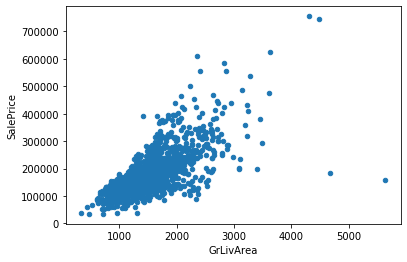

In [78]:
train.plot.scatter(x='GrLivArea', y='SalePrice')

In [20]:
train.columns.to_series().groupby(train.dtypes).groups

{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 

## Remove outliers automatically
Fail. Too many outliers from too many predictors.

(576, 74)


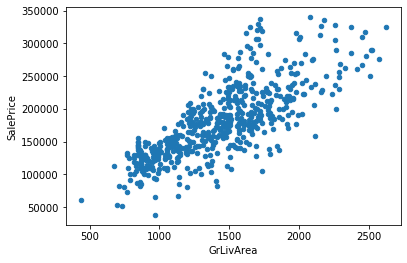

In [152]:
# Method 1: IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return df[trueList.all(axis=1)]

train = remove_outliers(train)
print(train.shape)

# Method 2: 3 sigma
df = train[(np.abs(stats.zscore(train.select_dtypes(exclude = ["object"]))) < 3).all(axis=1)]

In [107]:
df = pd.DataFrame.from_dict([{'a' : 100000, 'b' : '2'}, {'a' : 3, 'b' : '4000000'}, {'a' : 3, 'b' : '4'}, {'a' : 3, 'b' : '4'}, {'a' : 3, 'b' : '4'}])
#df = remove_outliers(df)
df.dtypes

a     int64
b    object
dtype: object

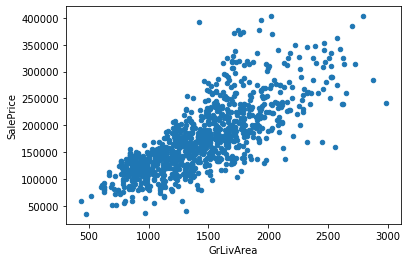

In [153]:
df = train[(np.abs(stats.zscore(train.select_dtypes(exclude = ["object"]))) < 3).all(axis=1)]
df.plot.scatter(x='GrLivArea', y='SalePrice')


In [120]:
stats.zscore(train.select_dtypes(exclude = ["object"]))[10]

array([-0.87256276,  0.06846888, -0.79515147, -0.51719981, -0.20759447,
       -0.96256569,         nan,  1.01407725, -0.28865283, -0.98081301,
       -0.03974291, -0.31731149, -0.79516323, -0.12024172, -0.90512725,
        1.10781015, -0.24106104, -1.02604084, -0.76162067,  0.16377912,
       -0.21145358, -0.93412978, -0.95122649,         nan, -1.02685765,
       -0.41631716, -0.75217584, -0.70448325, -0.3593249 , -0.11633929,
       -0.27020835, -0.06869175, -0.08768781, -1.5991111 ,  0.13877749,
       -0.64749741])

In [99]:
train[(np.abs(stats.zscore(train.select_dtypes(exclude = ["object"]))) < 3).all(axis=1)]
train

/Users/chenkongtao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [91]:
stats.zscore(df)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [154]:
train['SalePrice'].skew()

1.8828757597682129